# Imports

In [147]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Conv1D ,Input,MaxPooling1D, Dropout,AveragePooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
import keras.losses
from keras.optimizers import SGD
import pickle

# Functions

In [148]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [166]:
def feature_selection(images,variance_lower_limit):
    selector = VarianceThreshold(variance_lower_limit)
    images_reduced = selector.fit_transform(images)
    print("Images original shape: ",images.shape)
    print("Images reduced shape: ",images_reduced.shape)
    return images_reduced

In [149]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img,grayscale):
    x = img_to_array(img)/255.
    if grayscale==True:
        x = rgb2gray(x)   
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [150]:
 #https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [152]:
#convert the dataset with features the image names to dataset with features theflattened one hot encoding vectors of pixels
def create_flattened_dataset(dataset,size,grayscale):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        img_vector=load_reshape_img(img,grayscale)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
    dataset_np=np.stack(dataset_copy)
    dataset_pd = pd.DataFrame(dataset_np)
    return(dataset_pd)

In [153]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")
    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")    
    return

# Read Data

In [154]:
dataset = pd.read_csv('../Datasets/cartoon_set/labels.csv', sep = '\t', usecols = [2,3])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (10000, 2)


,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png


In [155]:
images = dataset.iloc[:,1]
labels = dataset.iloc[:,0]

Example of cartoons in Cartoon dataset:

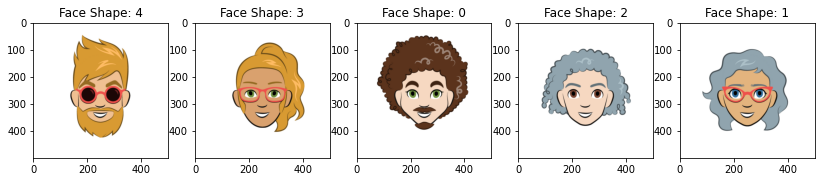

In [156]:
images_folder = '../Datasets/cartoon_set/img/'
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(14, 3))

EXAMPLE_PIC = images_folder + '0.png'
ax1.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax1.imshow(img)

EXAMPLE_PIC = images_folder + '2.png'
ax2.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax2.imshow(img)

EXAMPLE_PIC = images_folder + '3.png'
ax3.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax3.imshow(img)

EXAMPLE_PIC = images_folder + '4.png'
ax4.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax4.imshow(img)

EXAMPLE_PIC = images_folder + '8.png'
ax5.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax5.imshow(img)

## Elaborate on multiclass labels

Class=4, n=2000 (20.000%)
Class=3, n=2000 (20.000%)
Class=0, n=2000 (20.000%)
Class=2, n=2000 (20.000%)
Class=1, n=2000 (20.000%)


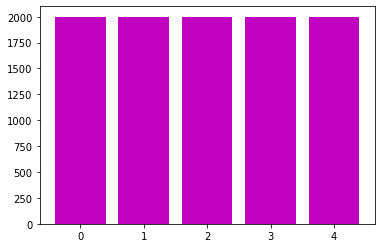

In [85]:
# summarize distribution
counter = Counter(labels)
for k,v in counter.items():
    per = v / len(labels) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values(),color='m')
plt.show()

**Balanced Dataset!!**

## Convert cartoon images dataframe to reshaped flattened array images dataframe

* As long as we are interested in cartoon's face shape, which don't need high resolution (since they are cartoons, not human faces), we reduce image shape from (IMG_HEIGHT,IMG_WIDTH)=(500,500) to 110 each and transform images to gray scale.

* We apply these transformatons from the beginning since we have quite a big dataset with high dimensional features that our computational resources cannot handle in their raw format.

Example of how images will be converted:

Step 1 image size: (500, 500, 3)
Step 2 image size: (110, 110, 3)
Step 3 image size: (110, 110, 1)


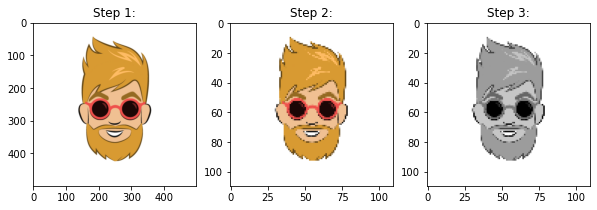

In [163]:
EXAMPLE_PIC = images_folder + '0.png'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

#original image size = (500,500,3)
img_original = load_img(EXAMPLE_PIC,target_size=(500,500))
ax1.imshow(img_original)
ax1.set_title("Step 1:")
print("Step 1 image size:",img_to_array(img_original).shape)

#reduced image size = (150,150,3)
img = load_img(EXAMPLE_PIC,target_size=(110,110))
ax2.imshow(img)
ax2.set_title("Step 2:")
print("Step 2 image size:",img_to_array(img).shape)

#grey image size = (150,150,1)
arr = img_to_array(img)
gray = rgb2gray(arr)   
ax3.imshow(gray, cmap=plt.get_cmap('gray'))
ax3.set_title("Step 3:")
print("Step 3 image size:",img_to_array(gray).shape)

plt.show()

In [164]:
size=(110,110) 
grayscale=True
reshaped_images=create_flattened_dataset(images,size,grayscale)
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.
Train Set: (7000, 12100) | Dev Set: (1500, 12100) | Test Set: (1500, 12100)


## Remove features with zero information (white pixels of background)

### Feature Selection:
If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed. 
In this problem, these constant fetures are the white pixels of background.

In [167]:
variance_lower_limit=0
reshaped_images_reduced=feature_selection(reshaped_images,variance_lower_limit)

Images original shape:  (10000, 12100)
Images reduced shape:  (10000, 6725)


## Split reshaped dataset into train, dev, test sets

In [168]:
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images_reduced, labels)

Train Set: (7000, 6725) | Dev Set: (1500, 6725) | Test Set: (1500, 6725)


# Baseline Multiclass Classification

## Linear SVM

# Preprocessing Data